In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
inflation = pd.read_csv('Price_index.csv',index_col = 0)

inflation.columns = ['price']
inflation['delta'] = ((inflation['price'] - inflation['price'].shift(12))/inflation['price']) * 100
inflation = inflation.loc['1976-01-01':'2017-03-01']
#print(inflation)


#plt.figure(1)
#inflation['delta'].plot()
#plt.show()

m2 = pd.read_csv('M2_USA.csv', index_col = 0)
m2.columns = ['M2']
m2['M2'] = m2['M2'] / 1000000000

savings = pd.read_csv('SAVINGSL.csv', index_col = 0)
savings.columns = ['Savings']

rapport = m2['M2']/savings['Savings']
difference = m2['M2'] - savings['Savings']
delta_difference = ((difference - difference.shift(12))/difference) * 100

rapport = pd.DataFrame(rapport)
rapport = rapport.loc['1976-01-01':'2017-03-01']
delta_difference = pd.DataFrame(delta_difference)
delta_difference = delta_difference.loc['1976-01-01':'2017-03-01']


## Je m'assure du type de données ##
inflation.astype(dtype = 'float')
rapport.astype(dtype = 'float')
delta_difference.astype(dtype = 'float')

delta_difference.columns=['0']

<Figure size 432x288 with 0 Axes>

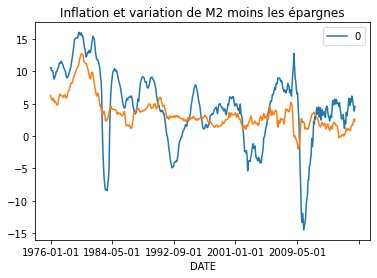

In [4]:
plt.figure()
delta_difference.plot()
inflation['delta'].plot()
plt.title('Inflation et variation de M2 moins les épargnes')
plt.show()

<Figure size 432x288 with 0 Axes>

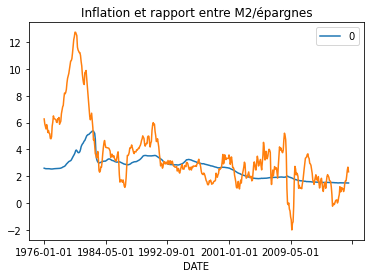

In [5]:
plt.figure()
rapport.plot()
inflation['delta'].plot()
plt.title('Inflation et rapport entre M2/épargnes')
plt.show()

In [15]:
############# Analyse statistique de base #############

## inlfation et delta différence entre 1976 et 2017 ##

x1 = inflation['delta'].values
y1 = delta_difference['0'].values

from scipy.stats import pearsonr
coeff_pearson = pearsonr(x1,y1)
print("coefficient de Pearson = {}".format(coeff_pearson))

coefficient de Pearson = (0.6141310647672451, 1.2020602172269806e-52)


In [16]:
## inlfation et delta différence entre 1985 et 2017 ##

delta_difference_1985 = delta_difference.loc['1985-01-01':'2017-03-01']
inflation_1985 = inflation.loc['1985-01-01':'2017-03-01']

x2 = inflation_1985['delta'].values
y2 = delta_difference_1985['0'].values

from scipy.stats import pearsonr
coeff_pearson = pearsonr(x2,y2)
print("coefficient de Pearson après 1985 = {}".format(coeff_pearson))

coefficient de Pearson après 1985 = (0.21137720411212665, 2.7615056876140095e-05)
